# **Accenture Datathon Challange**

## Imports

In [1]:
# Importem les llibreries necessàries
import pandas as pd
import numpy as np
import matplotlib as mp
import sklearn as sk
import seaborn as sns
import missingno as msno
import xgboost as xgb
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA # Per al PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

# Filtrem els warnings per no col·lapsar els outputs
pd.set_option('display.max_columns', None)
np.warnings.filterwarnings('ignore')

## Reading data

In [2]:
# read train data
df_orders = pd.read_csv("./Datathon DataSets/orders.csv", sep=";")
df_products = pd.read_csv("./Datathon DataSets/product_attributes.csv", sep=",")
df_dists = pd.read_csv("./Datathon DataSets/cities_data.csv", sep=";")
df_product_weight = pd.read_csv("./Datathon DataSets/product_weight_class.csv", sep = ",")
df_city_cost = pd.read_csv("./Datathon DataSets/cities_data_costs.csv", sep = ",")

# read test data
df_test = pd.read_csv("./Submission Kaggle/test.csv", sep=";")

## EDA

In [3]:
df_orders.columns

Index(['order_id', 'origin_port', '3pl', 'customs_procedures', 'logistic_hub',
       'customer', 'product_id', 'units', 'late_order'],
      dtype='object')

In [4]:
df_orders.head()

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,True
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,False
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,True
3,f5e98cb29790,Rotterdam,v_004,CRF,Lille,Milan,1620510,678,False
4,a9e7c9bee35b,Barcelona,v_002,CRF,Venlo,Berlin,1699372,353,False


In [5]:
df_orders.shape

(114276, 9)

In [6]:
df_orders.describe()

,product_id,units
count,1.142760e+05,114276.000000
mean,1.673412e+06,484.915310
std,5.805043e+04,68.387351
min,-1.000000e+00,1.000000
25%,1.658528e+06,447.000000
50%,1.681687e+06,486.000000
75%,1.692987e+06,522.000000
max,1.702654e+06,951.000000


## Preprocessing and feature engineering

In [7]:
df_orders["origin_port"] = df_orders["origin_port"].replace(["BCN"], "Barcelona")
df_orders["origin_port"] = df_orders["origin_port"].replace(["ATHENAS"], "Athens")

In [8]:
df_products = df_products.merge(df_product_weight, on="product_id")
df_orders.loc[df_orders.product_id == -1, "product_id"] = 1687644
df_city_cost = df_city_cost.drop(["city_from_coord","city_to_coord"], axis=1)
df_orders = df_orders.merge(df_products, on="product_id")
df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,True,1778,5,8
1,088f2e0d2138,Barcelona,v_004,DTD,Hamburg,Milan,1692723,385,False,1778,5,8
2,8ffc8fd4719e,Rotterdam,v_004,CRF,Dusseldorf,Amsterdam,1692723,484,False,1778,5,8
3,9efa143a9a01,Rotterdam,v_004,DTP,Rome,Cologne,1692723,408,False,1778,5,8
4,02532624e5c2,Athens,v_004,DTP,Lille,Bucharest,1692723,526,False,1778,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...
114271,47925983b3db,Rotterdam,v_004,CRF,Hamburg,Milan,1699562,460,False,386,2,0
114272,1a3b7ad82a7f,Athens,v_002,CRF,Liege,Berlin,1699562,471,False,386,2,0
114273,4db0de8d7b2a,Athens,v_002,DTD,Venlo,Copenhagen,1682594,581,False,1131,5,3
114274,eee4f5251165,Athens,v_004,CRF,Hamburg,Milan,1666470,459,False,896,0,2


In [9]:
# Cities in the first column from to hub
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["origin_port","logistic_hub","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_from_hub"] = df_orders["distance"]
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_from_hub"] = df_orders["cost_per_unit"]
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_from_hub"] = df_orders["co2_per_unit"]
df_orders = df_orders.drop("co2_per_unit", axis=1)

df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723.0,583.0,True,1778.0,5.0,8,130.0459,182.84,158.01
1,8e4f6905f8c4,Rotterdam,v_004,DTD,Venlo,Barcelona,1692723.0,359.0,False,1778.0,5.0,8,130.0459,182.84,158.01
2,9c76195e9555,Rotterdam,v_004,DTD,Venlo,Madrid,1692723.0,348.0,False,1778.0,5.0,8,130.0459,182.84,158.01
3,acaa6a72ad75,Rotterdam,v_004,CRF,Venlo,Naples,1692723.0,522.0,False,1778.0,5.0,8,130.0459,182.84,158.01
4,95d1b392d33a,Rotterdam,v_004,DTD,Venlo,Marseille,1692723.0,491.0,False,1778.0,5.0,8,130.0459,182.84,158.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,bea8bda3ffed,Barcelona,v_001,CRF,NaN,Amsterdam,1699552.0,586.0,True,1190.0,0.0,4,NaN,NaN,NaN
114272,01f10349fa3d,Barcelona,v_001,CRF,NaN,Athens,1689012.0,527.0,False,1192.0,3.0,4,NaN,NaN,NaN
114273,02d5a78564b9,Barcelona,v_001,CRF,NaN,Lyon,1657013.0,569.0,True,1285.0,0.0,4,NaN,NaN,NaN
114274,eac01c755f39,Barcelona,v_001,CRF,NaN,Madrid,1672347.0,453.0,False,1464.0,4.0,6,NaN,NaN,NaN


In [10]:
# Cities in the second column from to hub
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["logistic_hub","origin_port","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_from_hub"],df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_from_hub"],df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_from_hub"],df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)

df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723.0,583.0,True,1778.0,5.0,8,130.0459,182.84,158.01
1,8e4f6905f8c4,Rotterdam,v_004,DTD,Venlo,Barcelona,1692723.0,359.0,False,1778.0,5.0,8,130.0459,182.84,158.01
2,9c76195e9555,Rotterdam,v_004,DTD,Venlo,Madrid,1692723.0,348.0,False,1778.0,5.0,8,130.0459,182.84,158.01
3,acaa6a72ad75,Rotterdam,v_004,CRF,Venlo,Naples,1692723.0,522.0,False,1778.0,5.0,8,130.0459,182.84,158.01
4,95d1b392d33a,Rotterdam,v_004,DTD,Venlo,Marseille,1692723.0,491.0,False,1778.0,5.0,8,130.0459,182.84,158.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,bea8bda3ffed,Barcelona,v_001,CRF,NaN,Amsterdam,1699552.0,586.0,True,1190.0,0.0,4,NaN,NaN,NaN
114272,01f10349fa3d,Barcelona,v_001,CRF,NaN,Athens,1689012.0,527.0,False,1192.0,3.0,4,NaN,NaN,NaN
114273,02d5a78564b9,Barcelona,v_001,CRF,NaN,Lyon,1657013.0,569.0,True,1285.0,0.0,4,NaN,NaN,NaN
114274,eac01c755f39,Barcelona,v_001,CRF,NaN,Madrid,1672347.0,453.0,False,1464.0,4.0,6,NaN,NaN,NaN


In [11]:
# Cities in the first column hub to to
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["logistic_hub","customer","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)

df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub,distance_hub_to,cost_per_unit_hub_to,co2_per_unit_hub_to
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723.0,583.0,True,1778.0,5.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
1,95d1b392d33a,Rotterdam,v_004,DTD,Venlo,Marseille,1692723.0,491.0,False,1778.0,5.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
2,2125871f97e4,Rotterdam,v_004,CRF,Venlo,Marseille,1692723.0,452.0,False,1778.0,5.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
3,aa31856918fd,Rotterdam,v_004,CRF,Venlo,Marseille,1650715.0,419.0,False,1895.0,4.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
4,088916ff9134,Rotterdam,v_004,DTD,Venlo,Marseille,1650715.0,576.0,True,1895.0,4.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,a3fbf58969e9,Rotterdam,v_001,CRF,NaN,Copenhagen,1686764.0,619.0,False,1621.0,5.0,7,NaN,NaN,NaN,NaN,NaN,NaN
114272,b9b843b14368,Rotterdam,v_001,DTD,NaN,Prague,1698924.0,452.0,True,1641.0,2.0,7,NaN,NaN,NaN,NaN,NaN,NaN
114273,6ca7d8cb6219,Rotterdam,v_001,CRF,NaN,Bordeaux,1699315.0,516.0,False,1589.0,5.0,7,NaN,NaN,NaN,NaN,NaN,NaN
114274,888cb27c17e3,Rotterdam,v_001,DTP,NaN,Naples,1700143.0,545.0,False,1683.0,5.0,7,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Cities in the second column hub to to
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["customer","logistic_hub","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_hub_to"],df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_hub_to"],df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_hub_to"],df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)

df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub,distance_hub_to,cost_per_unit_hub_to,co2_per_unit_hub_to
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723.0,583.0,True,1778.0,5.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
1,95d1b392d33a,Rotterdam,v_004,DTD,Venlo,Marseille,1692723.0,491.0,False,1778.0,5.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
2,2125871f97e4,Rotterdam,v_004,CRF,Venlo,Marseille,1692723.0,452.0,False,1778.0,5.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
3,aa31856918fd,Rotterdam,v_004,CRF,Venlo,Marseille,1650715.0,419.0,False,1895.0,4.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
4,088916ff9134,Rotterdam,v_004,DTD,Venlo,Marseille,1650715.0,576.0,True,1895.0,4.0,8,130.0459,182.84,158.01,902.042,654.34,1095.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,a3fbf58969e9,Rotterdam,v_001,CRF,NaN,Copenhagen,1686764.0,619.0,False,1621.0,5.0,7,NaN,NaN,NaN,NaN,NaN,NaN
114272,b9b843b14368,Rotterdam,v_001,DTD,NaN,Prague,1698924.0,452.0,True,1641.0,2.0,7,NaN,NaN,NaN,NaN,NaN,NaN
114273,6ca7d8cb6219,Rotterdam,v_001,CRF,NaN,Bordeaux,1699315.0,516.0,False,1589.0,5.0,7,NaN,NaN,NaN,NaN,NaN,NaN
114274,888cb27c17e3,Rotterdam,v_001,DTP,NaN,Naples,1700143.0,545.0,False,1683.0,5.0,7,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def isNaN(string):
    return string != string

# Feature engineering for data without hub and total calculus
df_orders = df_orders.merge(df_city_cost, how="outer", left_on=["origin_port","customer","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["distance"], df_orders["distance_from_hub"], df_orders["distance_hub_to"]))
df_orders["distance_ideal"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["origin_port"], df_orders["customer"], df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["cost_per_unit"], df_orders["cost_per_unit_from_hub"], df_orders["cost_per_unit_hub_to"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["co2_per_unit"], df_orders["co2_per_unit_from_hub"], df_orders["co2_per_unit_hub_to"]))
df_orders = df_orders.drop("co2_per_unit",axis=1)

df_orders = df_orders.merge(df_city_cost, how="outer", left_on=["origin_port","customer","weight_class"], right_on=["city_to_name","city_from_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_total"], df_orders["distance"]))
df_orders["distance_ideal"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_ideal"], df_orders["distance"]))
df_orders["cost_per_unit_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_total"], df_orders["cost_per_unit"]))
df_orders["co2_per_unit_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_total"], df_orders["co2_per_unit"]))
df_orders = df_orders.drop(["distance","cost_per_unit","co2_per_unit"], axis=1)

df_orders["distance_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["distance_total"]))
df_orders["cost_per_unit_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["co2_per_unit_total"]))

df_orders["distance_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["distance_from_hub"], df_orders["distance_total"]))
df_orders["cost_per_unit_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["cost_per_unit_from_hub"], df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["co2_per_unit_from_hub"], df_orders["co2_per_unit_total"]))
df_orders["distance_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["distance_hub_to"], df_orders["distance_total"]))
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["cost_per_unit_hub_to"], df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["co2_per_unit_hub_to"], df_orders["co2_per_unit_total"]))

df_orders["logistic_hub"] = list(map(lambda x: "No" if isNaN(x) else x, df_orders["logistic_hub"]))

df_orders["late_order"] = list(map(int, df_orders["late_order"])) #Ask Pau

df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub,distance_hub_to,cost_per_unit_hub_to,co2_per_unit_hub_to,distance_total,distance_ideal,cost_per_unit_total,co2_per_unit_total
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723.0,583.0,1,1778.0,5.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99
1,95d1b392d33a,Rotterdam,v_004,DTD,Venlo,Marseille,1692723.0,491.0,0,1778.0,5.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99
2,2125871f97e4,Rotterdam,v_004,CRF,Venlo,Marseille,1692723.0,452.0,0,1778.0,5.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99
3,aa31856918fd,Rotterdam,v_004,CRF,Venlo,Marseille,1650715.0,419.0,0,1895.0,4.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99
4,088916ff9134,Rotterdam,v_004,DTD,Venlo,Marseille,1650715.0,576.0,1,1895.0,4.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,846cdec18c59,Barcelona,v_004,DTD,Dusseldorf,Porto,1699239.0,581.0,0,1684.0,1.0,7,1149.4065,708.55,1318.94,1626.5104,857.51,1866.42,2775.9169,903.7955,1566.06,3185.36
114272,cd909ac43c1a,Barcelona,v_002,DTD,Dusseldorf,Porto,1662238.0,470.0,0,1572.0,0.0,7,1149.4065,708.55,1318.94,1626.5104,857.51,1866.42,2775.9169,903.7955,1566.06,3185.36
114273,0520409cafbf,Barcelona,v_002,DTD,Lille,Porto,1699239.0,413.0,1,1684.0,1.0,7,1030.8249,666.59,1182.87,1386.9211,786.13,1591.49,2417.7460,903.7955,1452.72,2774.36
114274,a095e7b8b3f2,Barcelona,v_002,DTD,Lille,Porto,1672706.0,377.0,1,1684.0,5.0,7,1030.8249,666.59,1182.87,1386.9211,786.13,1591.49,2417.7460,903.7955,1452.72,2774.36


In [14]:
country = {}
country['Amsterdam'] = 'Netherlands'
country['Athens'] = 'Greece'
country['Barcelona'] = 'Spain'
country['Berlin'] = 'Germany'
country['Bordeaux'] = 'France'
country['Bratislava'] = 'Slovakia'
country['Bremen'] = 'Germany'
country['Bucharest'] = 'Romania'
country['Budapest'] = 'Hungary'
country['Cologne'] = 'Germany'
country['Copenhagen'] = 'Denmark'
country['Dusseldorf'] = 'Germany'
country['Hamburg'] = 'Germany'
country['Hanover'] = 'Germany'
country['Helsinki'] = 'Finland'
country['Liege'] = 'Belgium'
country['Lille'] = 'France'
country['Lisbon'] = 'Portugal'
country['Lyon'] = 'France'
country['Madrid'] = 'Spain'
country['Malmö'] = 'Sweden'
country['Marseille'] = 'France'
country['Milan'] = 'Italy'
country['Munich'] = 'Germany'
country['Naples'] = 'Italy'
country['Paris'] = 'France'
country['Porto'] = 'Portugal'
country['Prague'] = 'Czech Republic'
country['Rome'] = 'Italy'
country['Rotterdam'] = 'Netherlands'
country['Stockholm'] = 'Sweden'
country['Turin'] = 'Italy'
country['Valencia'] = 'Spain'
country['Venlo'] = 'Netherlands'
country['Vienna'] = 'Austria'
country['Warsaw'] = 'Poland'
country['Zaragoza'] = 'Spain'

df_orders["origin_country"] = list(map(lambda x: country[x], df_orders["origin_port"]))
df_orders["hub_country"] = list(map(lambda x: "No" if x == "No" else country[x], df_orders["logistic_hub"]))
df_orders["customer_country"] = list(map(lambda x: country[x], df_orders["customer"]))

df_orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,weight_class,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub,distance_hub_to,cost_per_unit_hub_to,co2_per_unit_hub_to,distance_total,distance_ideal,cost_per_unit_total,co2_per_unit_total,origin_country,hub_country,customer_country
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723.0,583.0,1,1778.0,5.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,Netherlands,France
1,95d1b392d33a,Rotterdam,v_004,DTD,Venlo,Marseille,1692723.0,491.0,0,1778.0,5.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,Netherlands,France
2,2125871f97e4,Rotterdam,v_004,CRF,Venlo,Marseille,1692723.0,452.0,0,1778.0,5.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,Netherlands,France
3,aa31856918fd,Rotterdam,v_004,CRF,Venlo,Marseille,1650715.0,419.0,0,1895.0,4.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,Netherlands,France
4,088916ff9134,Rotterdam,v_004,DTD,Venlo,Marseille,1650715.0,576.0,1,1895.0,4.0,8,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,Netherlands,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,846cdec18c59,Barcelona,v_004,DTD,Dusseldorf,Porto,1699239.0,581.0,0,1684.0,1.0,7,1149.4065,708.55,1318.94,1626.5104,857.51,1866.42,2775.9169,903.7955,1566.06,3185.36,Spain,Germany,Portugal
114272,cd909ac43c1a,Barcelona,v_002,DTD,Dusseldorf,Porto,1662238.0,470.0,0,1572.0,0.0,7,1149.4065,708.55,1318.94,1626.5104,857.51,1866.42,2775.9169,903.7955,1566.06,3185.36,Spain,Germany,Portugal
114273,0520409cafbf,Barcelona,v_002,DTD,Lille,Porto,1699239.0,413.0,1,1684.0,1.0,7,1030.8249,666.59,1182.87,1386.9211,786.13,1591.49,2417.7460,903.7955,1452.72,2774.36,Spain,France,Portugal
114274,a095e7b8b3f2,Barcelona,v_002,DTD,Lille,Porto,1672706.0,377.0,1,1684.0,5.0,7,1030.8249,666.59,1182.87,1386.9211,786.13,1591.49,2417.7460,903.7955,1452.72,2774.36,Spain,France,Portugal


In [15]:
busy_road = {}
busy_road['Bulgaria'] = 171.1
busy_road['Czech Republic'] = 96.7
busy_road['Italy'] = 77.7
busy_road['Germany'] = 72.1
busy_road['Romania'] = 65.7
busy_road['Switzerland'] = 64.9
busy_road['Netherlands'] = 61.8
busy_road['Portugal'] = 55.9
busy_road['Poland'] = 53.0
busy_road['Belgium'] = 48.4
busy_road['Ukraine'] = 46.2
busy_road['Greece'] = 44.9
busy_road['Slovakia'] = 38.8
busy_road['Russia'] = 38.0
busy_road['Denmark'] = 35.8
busy_road['Austria'] = 33.4
busy_road['Spain'] = 33.1
busy_road['France'] = 30.7
busy_road['Norway'] = 28.7
busy_road['Slovenia'] = 28.7
busy_road['Hungary'] = 16.0
busy_road['Sweden'] = 8.3
busy_road['Finland'] = 5.8


scaler = StandardScaler() 
valor_pais = scaler.fit_transform(np.array(list(busy_road.values())).reshape(-1,1)).flatten()
i = 0
for key in busy_road.keys():
    busy_road[key] = valor_pais[i]
    i+=1


nom_pais = ["Norway", "Switzerland", "Sweden", "-", "Denmark", "Spain", "Ireland", "Netherlands", "Germany", "Austria", "Slovenia", "France", "Finland", "Italy", "Luxembourg", "Belgium","-", "Slovakia", "Hungary", "Czech Republic", "Portugal", "-", "Greece", "-", "-", "Poland", "Bulgaria", "-", "Romania", "Russia", "Ukraine"]
valor_pais = [17, 17, 18, 21, 27, 29, 30 , 31, 33, 38, 38, 39, 40, 40, 42, 44, 45, 45, 46, 48, 52, 54, 54, 58, 63, 65, 67, 74, 85, 100, 93]

scaler = StandardScaler() 
valor_pais = scaler.fit_transform(np.array(valor_pais).reshape(-1,1)).flatten()

road_accidents = dict()
for nom,valor in zip(nom_pais,valor_pais):
    road_accidents[nom] = valor

hash_ACR = ["NO", "CH", "SE", "-", "DK", "ES", "IE", "NL","DE","AT", "SI","FR","FI","IT","LU","BE", "SK","HU","CZ","PT","GR","PL","BG","RO","RU","UA"]
hash_key = {x:y for x,y in zip(list(road_accidents.keys()),hash_ACR)}
### PAU fes aquí lo del busy rate (aquest és le nom d'una de les dues columnes, la fórmula seria traffic_rate)

In [16]:
from Country_Borders_Files import graph
from Country_Borders_Files.borders import country_border_graph, country_code_lookup, find_shortest_path


def find_paths(origen, destination):
    '''
    Takes the origin and destination in format: "IT"
    Returns a list with the names of the path between origin and destination in format: "Italy"
    '''
    path = find_shortest_path(country_border_graph, origen, destination)
    path_names = [country_code_lookup[code] for code in path]
    return path_names


def all_paths(origen, hub, destination):
    if hub == 'No':
        return find_paths(hash_key[origen], hash_key[destination])
    
    paths = find_paths(hash_key[origen], hash_key[hub])
    paths.extend(find_paths(hash_key[hub], hash_key[destination]))
    
    return list(set(paths))

In [17]:
df_orders["col_aux"] = list(map(all_paths, df_orders["origin_country"], df_orders["hub_country"], df_orders["customer_country"]))

In [18]:
# Find all the countries we went through
paisos_set = set()
for i in range(len(df_orders)):
    for x in df_orders.loc[i]["col_aux"]:
        paisos_set.add(x)

In [19]:
# Add new column for each country
for i in list(paisos_set):
    df_orders[i] = np.zeros(len(df_orders))

In [20]:
df_orders.columns[26:]

Index(['Sweden', 'Spain', 'Greece', 'Portugal', 'Netherlands', 'Denmark',
       'Slovakia', 'Russian Federation', 'Ukraine', 'Croatia', 'France',
       'Finland', 'Belgium', 'Bulgaria', 'Turkey', 'Hungary', 'Poland',
       'Czechia', 'Azerbaijan', 'Albania', 'Romania', 'Austria', 'Italy',
       'Montenegro', 'Serbia', 'Slovenia', 'Germany'],
      dtype='object')

In [21]:
for col in df_orders.columns[26:]:
    df_orders[col] = list(map(lambda x: 1 if col in x else 0, df_orders["col_aux"]))

In [22]:
df_orders.drop("col_aux", axis=1, inplace=True)

In [23]:
def accidents_path(origen,destination):
    '''
    Takes the origin and destination in format: "Italy"
    Returns a number corresponding to the indice of accidents thoughout the path
    '''
    if origen == "No" or destination == "No":
        return 0
    
    path = find_paths(hash_key[origen], hash_key[destination])
    
    accidents = 0
    len_path = 0
    keys = road_accidents.keys()
    for country in path:
        if country in keys:
            accidents += road_accidents[country] 
            len_path+=1
        
    accidents/= len_path
    
    return accidents


def traffic_path(origen,destination):
    '''
    Takes the origin and destination in format: "Italy"
    Returns a number corresponding to the indice of traffic thoughout the path
    '''
    if origen == "No" or destination == "No":
        return 0
    
    path = find_paths(hash_key[origen], hash_key[destination])
    
    accidents = 0
    len_path = 0
    keys = busy_road.keys()
    for country in path:
        if country in keys:
            accidents += busy_road[country] 
            len_path+=1
        
    accidents/= len_path
    
    return accidents   


In [24]:
df_orders["accidents_path_originhub"] = list(map(accidents_path, df_orders["origin_country"], df_orders["hub_country"]))
df_orders["accidents_path_hubcostumer"] = list(map(accidents_path, df_orders["hub_country"], df_orders["customer_country"]))

df_orders["traffic_path_originhub"] = list(map(traffic_path, df_orders["origin_country"], df_orders["hub_country"]))
df_orders["traffic_path_hubcostumer"] = list(map(traffic_path, df_orders["hub_country"], df_orders["customer_country"]))

df_orders["traf_acc_dist_originhub"] = (df_orders["accidents_path_originhub"] + df_orders["traffic_path_originhub"])* df_orders["distance_from_hub"]
df_orders["traf_acc_dist_hubcostumer"] = (df_orders["accidents_path_hubcostumer"] + df_orders["traffic_path_hubcostumer"])* df_orders["distance_hub_to"]

In [25]:
# Outlier dropping (we don't do it because we have to predict them anyway)

# product id = -1 (118 samples) dropped
# df_orders.drop(np.where(df_orders["product_id"] == -1)[0], inplace = True)

In [26]:
# Mean Encoding
target = "late_order"
atrs_to_me = ["product_id", "hub_country", "customer_country"]
to_drop = ["order_id", "weight_class"]

df_orders.drop(to_drop, axis="columns", inplace=True)

# For the final prediction
encodings_list = []

for atr in atrs_to_me:
    mean_encoded = df_orders.groupby([atr])[target].mean().to_dict()
    encodings_list.append(mean_encoded)
    df_orders[atr] = df_orders[atr].map(mean_encoded)

df_orders

,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order,weight,material_handling,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub,distance_hub_to,cost_per_unit_hub_to,co2_per_unit_hub_to,distance_total,distance_ideal,cost_per_unit_total,co2_per_unit_total,origin_country,hub_country,customer_country,Sweden,Spain,Greece,Portugal,Netherlands,Denmark,Slovakia,Russian Federation,Ukraine,Croatia,France,Finland,Belgium,Bulgaria,Turkey,Hungary,Poland,Czechia,Azerbaijan,Albania,Romania,Austria,Italy,Montenegro,Serbia,Slovenia,Germany,accidents_path_originhub,accidents_path_hubcostumer,traffic_path_originhub,traffic_path_hubcostumer,traf_acc_dist_originhub,traf_acc_dist_hubcostumer
0,Rotterdam,v_002,DTP,Venlo,Marseille,0.244275,583.0,1,1778.0,5.0,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,-54.287945,-471.963652
1,Rotterdam,v_004,DTD,Venlo,Marseille,0.244275,491.0,0,1778.0,5.0,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,-54.287945,-471.963652
2,Rotterdam,v_004,CRF,Venlo,Marseille,0.244275,452.0,0,1778.0,5.0,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,-54.287945,-471.963652
3,Rotterdam,v_004,CRF,Venlo,Marseille,0.580375,419.0,0,1895.0,4.0,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,-54.287945,-471.963652
4,Rotterdam,v_004,DTD,Venlo,Marseille,0.580375,576.0,1,1895.0,4.0,130.0459,182.84,158.01,902.0420,654.34,1095.98,1032.0879,961.6350,837.18,1253.99,Netherlands,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,-54.287945,-471.963652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,Barcelona,v_004,DTD,Dusseldorf,Porto,0.183594,581.0,0,1684.0,1.0,1149.4065,708.55,1318.94,1626.5104,857.51,1866.42,2775.9169,903.7955,1566.06,3185.36,Spain,0.195335,0.323712,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.633415,-0.413551,-0.147286,-0.068401,-897.343676,-783.900851
114272,Barcelona,v_002,DTD,Dusseldorf,Porto,0.155709,470.0,0,1572.0,0.0,1149.4065,708.55,1318.94,1626.5104,857.51,1866.42,2775.9169,903.7955,1566.06,3185.36,Spain,0.195335,0.323712,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.633415,-0.413551,-0.147286,-0.068401,-897.343676,-783.900851
114273,Barcelona,v_002,DTD,Lille,Porto,0.183594,413.0,1,1684.0,1.0,1030.8249,666.59,1182.87,1386.9211,786.13,1591.49,2417.7460,903.7955,1452.72,2774.36,Spain,0.359582,0.323712,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.617425,-0.329603,-0.546177,-0.308033,-1199.469587,-884.350974
114274,Barcelona,v_002,DTD,Lille,Porto,0.170290,377.0,1,1684.0,5.0,1030.8249,666.59,1182.87,1386.9211,786.13,1591.49,2417.7460,903.7955,1452.72,2774.36,Spain,0.359582,0.323712,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.617425,-0.329603,-0.546177,-0.308033,-1199.469587,-884.350974


In [27]:
# One hot encoding
to_onehot = ["logistic_hub", "customer", 'origin_port','origin_country','3pl','customs_procedures','material_handling']
df_to_onehot = df_orders[to_onehot]
df_encoded = pd.get_dummies(df_to_onehot, drop_first = True)

# Drop non encodded variabes from dataset
df_orders = df_orders.drop(to_onehot, axis=1)

# Add the encoded dataset to the train dataset
df_orders = pd.concat([df_orders, df_encoded], axis=1)

In [28]:
# Normalization
from sklearn.preprocessing import StandardScaler
import numpy as np

to_scale = ["traf_acc_dist_originhub","traf_acc_dist_hubcostumer","units", "weight", "distance_from_hub", "cost_per_unit_from_hub", "co2_per_unit_from_hub","distance_hub_to", "cost_per_unit_hub_to", "co2_per_unit_hub_to","distance_total", "distance_ideal","cost_per_unit_total", "co2_per_unit_total"] #incluir distancies i tal
my_scalers = []


for atr in to_scale:
    scaler = StandardScaler() 
    df_orders[atr] = scaler.fit_transform(np.array(df_orders[atr]).reshape(-1,1))
    my_scalers.append(scaler)

<AxesSubplot:>

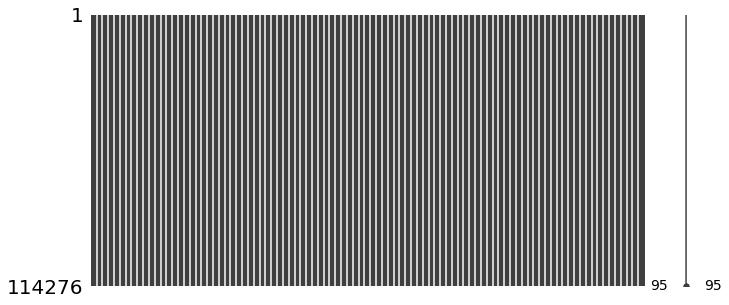

In [29]:
# NaN visualization
msno.matrix(df_orders, figsize=(11, 5))

In [30]:
# % of NaNs per atribute
df_orders.isnull().sum()/len(df_orders)*100

product_id                0.0
units                     0.0
late_order                0.0
weight                    0.0
distance_from_hub         0.0
                         ... 
3pl_v_002                 0.0
3pl_v_003                 0.0
3pl_v_004                 0.0
customs_procedures_DTD    0.0
customs_procedures_DTP    0.0
Length: 95, dtype: float64

In [31]:
"""
# Calculem la correlació entre les variables
correlation = df_orders.corr()
# Visualitzem un mapa de calor
sns.set(rc={'figure.figsize':(14*1.5,6*1.5)})
sns.heatmap(correlation, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
"""

"\n# Calculem la correlació entre les variables\ncorrelation = df_orders.corr()\n# Visualitzem un mapa de calor\nsns.set(rc={'figure.figsize':(14*1.5,6*1.5)})\nsns.heatmap(correlation, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))\n"

## Model selection

Train test split

In [32]:
data_feat = df_orders.drop('late_order',axis=1)

data_target = df_orders['late_order']

X_train, X_test, y_train, y_test = train_test_split(data_feat, data_target, test_size=0.30, random_state=101, stratify=data_target)

### Logistic Regression

In [33]:
df_orders

,product_id,units,late_order,weight,distance_from_hub,cost_per_unit_from_hub,co2_per_unit_from_hub,distance_hub_to,cost_per_unit_hub_to,co2_per_unit_hub_to,distance_total,distance_ideal,cost_per_unit_total,co2_per_unit_total,hub_country,customer_country,Sweden,Spain,Greece,Portugal,Netherlands,Denmark,Slovakia,Russian Federation,Ukraine,Croatia,France,Finland,Belgium,Bulgaria,Turkey,Hungary,Poland,Czechia,Azerbaijan,Albania,Romania,Austria,Italy,Montenegro,Serbia,Slovenia,Germany,accidents_path_originhub,accidents_path_hubcostumer,traffic_path_originhub,traffic_path_hubcostumer,traf_acc_dist_originhub,traf_acc_dist_hubcostumer,material_handling,logistic_hub_Dusseldorf,logistic_hub_Hamburg,logistic_hub_Liege,logistic_hub_Lille,logistic_hub_No,logistic_hub_Rome,logistic_hub_Venlo,logistic_hub_Warsaw,logistic_hub_Zaragoza,customer_Athens,customer_Barcelona,customer_Berlin,customer_Bordeaux,customer_Bremen,customer_Bucharest,customer_Budapest,customer_Cologne,customer_Copenhagen,customer_Hanover,customer_Helsinki,customer_Lisbon,customer_Lyon,customer_Madrid,customer_Malmö,customer_Marseille,customer_Milan,customer_Munich,customer_Naples,customer_Paris,customer_Porto,customer_Prague,customer_Rome,customer_Stockholm,customer_Turin,customer_Valencia,customer_Vienna,origin_port_Barcelona,origin_port_Rotterdam,origin_country_Netherlands,origin_country_Spain,3pl_v_002,3pl_v_003,3pl_v_004,customs_procedures_DTD,customs_procedures_DTP
0,0.244275,1.434258,1,0.994018,-1.264815,-1.183680,-1.147816,-0.110848,0.683662,0.299116,-1.028472,-0.311349,-0.455489,-0.662271,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,0.300298,-0.250982,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1
1,0.244275,0.088974,0,0.994018,-1.264815,-1.183680,-1.147816,-0.110848,0.683662,0.299116,-1.028472,-0.311349,-0.455489,-0.662271,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,0.300298,-0.250982,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
2,0.244275,-0.481309,0,0.994018,-1.264815,-1.183680,-1.147816,-0.110848,0.683662,0.299116,-1.028472,-0.311349,-0.455489,-0.662271,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,0.300298,-0.250982,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,0.580375,-0.963857,0,1.221969,-1.264815,-1.183680,-1.147816,-0.110848,0.683662,0.299116,-1.028472,-0.311349,-0.455489,-0.662271,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,0.300298,-0.250982,4.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
4,0.580375,1.331900,1,1.221969,-1.264815,-1.183680,-1.147816,-0.110848,0.683662,0.299116,-1.028472,-0.311349,-0.455489,-0.662271,0.187384,0.318096,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.761336,-0.425544,0.343884,-0.097673,0.300298,-0.250982,4.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,0.183594,1.405013,0,0.810879,0.223126,0.785233,0.506629,1.253134,1.655455,1.683045,0.909635,-0.404155,1.462266,1.339727,0.195335,0.323712,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.633415,-0.413551,-0.147286,-0.068401,-0.775657,-0.825456,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0
114272,0.155709,-0.218101,0,0.592670,0.223126,0.

In [34]:
# Regressió logística
t0 = time.time()
clf = LogisticRegression(random_state=123).fit(X_train, y_train)

# Calculem l'score ROC AUC de la regressió logística
ROC_LR = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print("Execution time:",(time.time()-t0)/60,"minutes.")
print("ROC AUC Logistic Regression:", ROC_LR)

Execution time: 0.040071479479471844 minutes.
ROC AUC Logistic Regression: 0.8288609220442745


In [35]:
df_orders.columns

Index(['product_id', 'units', 'late_order', 'weight', 'distance_from_hub',
       'cost_per_unit_from_hub', 'co2_per_unit_from_hub', 'distance_hub_to',
       'cost_per_unit_hub_to', 'co2_per_unit_hub_to', 'distance_total',
       'distance_ideal', 'cost_per_unit_total', 'co2_per_unit_total',
       'hub_country', 'customer_country', 'Sweden', 'Spain', 'Greece',
       'Portugal', 'Netherlands', 'Denmark', 'Slovakia', 'Russian Federation',
       'Ukraine', 'Croatia', 'France', 'Finland', 'Belgium', 'Bulgaria',
       'Turkey', 'Hungary', 'Poland', 'Czechia', 'Azerbaijan', 'Albania',
       'Romania', 'Austria', 'Italy', 'Montenegro', 'Serbia', 'Slovenia',
       'Germany', 'accidents_path_originhub', 'accidents_path_hubcostumer',
       'traffic_path_originhub', 'traffic_path_hubcostumer',
       'traf_acc_dist_originhub', 'traf_acc_dist_hubcostumer',
       'material_handling', 'logistic_hub_Dusseldorf', 'logistic_hub_Hamburg',
       'logistic_hub_Liege', 'logistic_hub_Lille', 'logi

In [36]:
clf.coef_

array([[ 6.08210346e+00,  5.14406446e-01,  3.15116528e-02,
         3.00481224e-01,  1.12946414e-01, -2.61291112e-01,
         1.22685570e-01,  5.41630761e-02, -4.05792137e-02,
         3.01211171e-01,  1.59988187e-02,  1.09140593e-01,
        -2.13470555e-01,  2.68218633e-02,  1.24363861e-01,
         3.85159790e-02, -6.79097261e-02,  1.86880101e-02,
         1.97591667e-01, -3.41067290e-02,  1.74595909e-01,
         2.91578273e-01,  6.22144717e-02, -1.01541104e-02,
        -8.60996767e-02,  2.24745839e-02,  1.10013902e-01,
         2.57297269e-02, -8.67834126e-02, -4.77994301e-02,
         9.01084769e-03,  5.29537072e-02, -7.24698794e-03,
        -4.77994301e-02, -1.70843945e-01, -1.74071876e-03,
         2.67432589e-02,  2.16565675e-02, -8.60996767e-02,
        -8.47442685e-02, -8.60996767e-02,  2.97338315e-02,
        -3.09621446e-02,  2.91324418e-02,  2.32528860e-01,
         4.97923638e-02, -7.68502476e-02, -5.25821217e-03,
        -1.96321337e-04, -6.47905050e-01, -6.81173456e-0

In [37]:
np.argsort(clf.coef_)

array([[89, 90, 91, 56, 50, 49, 55, 86, 87, 88, 85, 63, 51,  5, 62, 64,
        12, 54, 76, 34, 82, 79, 80, 67, 84, 65, 71, 75, 60, 74, 58, 28,
        40, 24, 38, 39, 46, 16, 29, 33,  8, 19, 42, 23, 81, 32, 59, 47,
        35, 48, 83, 30, 10, 17, 37, 25, 27, 36, 13, 43, 41,  2, 15, 72,
        45, 31,  7, 22, 68, 78, 69, 11, 26,  4,  6, 14, 53, 66, 20, 18,
        44, 21,  3,  9, 57, 92,  1, 61, 73, 77, 52, 70, 93,  0]],
      dtype=int64)

In [38]:
print(df_orders.columns[0],df_orders.columns[93], df_orders.columns[70], df_orders.columns[52])

product_id customs_procedures_DTD customer_Lisbon logistic_hub_Liege


### KNN Classifier

In [39]:
"""
# Inicialització i fit del KNN Classifier
t0 = time.time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

# Calculem l'score ROC AUC del KNN Classifier
ROC_KNC = roc_auc_score(y_test, neigh.predict_proba(X_test)[:,1])
print("Execution time:",(time.time()-t0)/60,"minutes.")
print("ROC AUC KNN Classifier:", ROC_KNC)
"""

'\n# Inicialització i fit del KNN Classifier\nt0 = time.time()\nneigh = KNeighborsClassifier(n_neighbors=3)\nneigh.fit(X_train, y_train)\n\n# Calculem l\'score ROC AUC del KNN Classifier\nROC_KNC = roc_auc_score(y_test, neigh.predict_proba(X_test)[:,1])\nprint("Execution time:",(time.time()-t0)/60,"minutes.")\nprint("ROC AUC KNN Classifier:", ROC_KNC)\n'

### Random Forest

In [40]:
# Inicialitzem i fem fit del Random Forest
t0 = time.time()
rf_model = RFC(n_estimators=10, random_state=123, n_jobs=4)
rf_model.fit(X_train, y_train)

# Fem prediccions i evaluem el seu ROC AUC score
pred_rf_valid = rf_model.predict_proba(X_test)[:,1]
ROC_RF = roc_auc_score(y_test, pred_rf_valid)
print("Execution time:",(time.time()-t0)/60,"minutes.")
print("ROC AUC Random Forest:", ROC_RF)

Execution time: 0.01748497486114502 minutes.
ROC AUC Random Forest: 0.7640577871246996


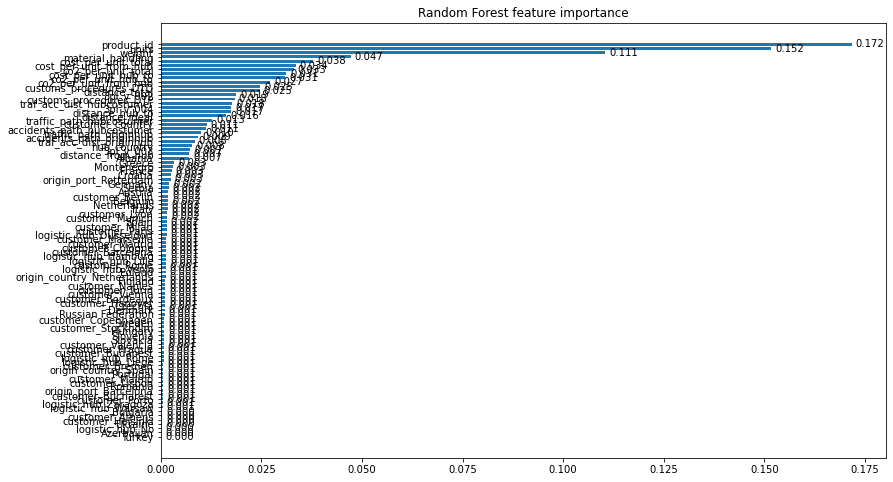

In [41]:
# Feature importance del RF
plt.rcParams["figure.figsize"] = (13,8)
sorted_index = rf_model.feature_importances_.argsort()
parameters = list(X_train.columns)
plt.barh([parameters[i] for i in sorted_index], rf_model.feature_importances_[sorted_index], height=.7)
plt.title('Random Forest feature importance')
for x, y in zip(rf_model.feature_importances_[sorted_index], np.arange(len(parameters))):
  plt.text(x + .001, y, f'{x:.3f}', va='center')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### XGBoost

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'nthread': 4,
    'max_depth': 3,
    'gamma':0,
    'min_child_weight':5,
    'colsample_bytree':1,
    'objective': 'binary:logistic',
    'eval_metric' : ['auc']
}
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = 100 #nombre d'arbres
t0 = time.time()
xgb_model = xgb.train(param, dtrain, num_round, evallist, verbose_eval = 25)

prob_xg_valid = xgb_model.predict(dvalid)
#pred_xg_valid = [1 if prob >= 0.5 else 0 for prob in prob_xg_valid]
ROC_XGB = roc_auc_score(y_test, prob_xg_valid)
print("Execution time:",(time.time()-t0)/60,"minutes.")
print("ROC AUC XGBoost:", ROC_XGB)

[0]	eval-auc:0.75877	train-auc:0.76101
[25]	eval-auc:0.83554	train-auc:0.84250
[50]	eval-auc:0.83865	train-auc:0.84794
[75]	eval-auc:0.83906	train-auc:0.85075
[99]	eval-auc:0.83955	train-auc:0.85317
Execution time: 0.112473197778066 minutes.
ROC AUC XGBoost: 0.8395532344734226


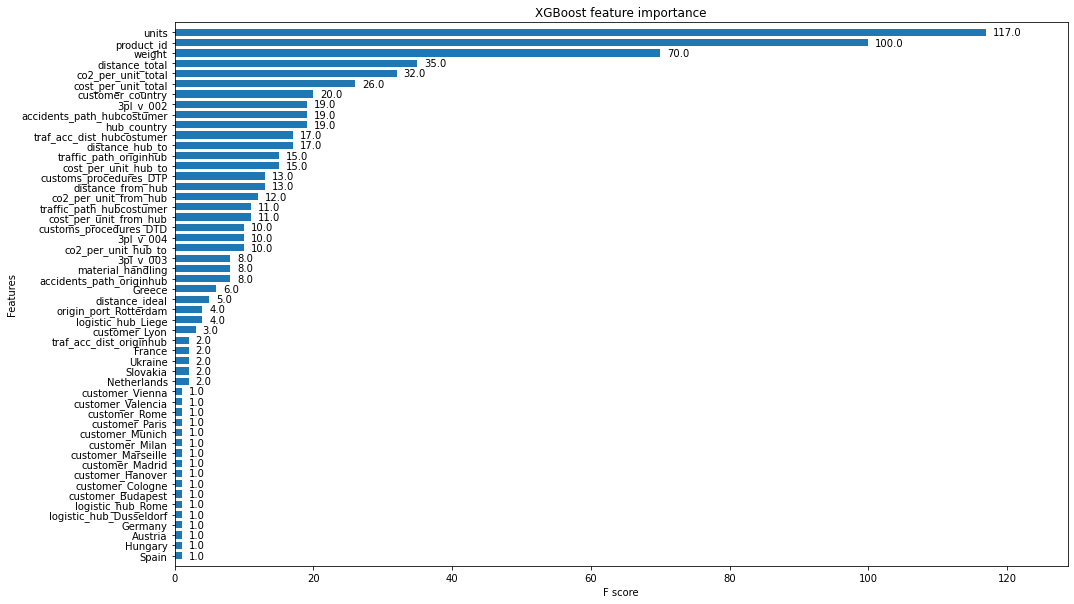

In [43]:
# Feature importance XGBoost
plt.rcParams["figure.figsize"] = (16,10)
plot_importance(xgb_model, height=0.7, grid=False, title="XGBoost feature importance")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [44]:
# Plain accuracy
from sklearn.metrics import accuracy_score
pred_xg_valid = [1 if prob >= 0.5 else 0 for prob in prob_xg_valid]
ACC_XGB = accuracy_score(y_test, pred_xg_valid)
print("ACC XGBoost:", ACC_XGB)

ACC XGBoost: 0.8281072251553248


In [45]:
# Hyperparameter search for XGBoost
"""
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

xgb_m = XGBClassifier(learning_rate=0.02, n_estimators=150, objective='binary:logistic', nthread=1)

params = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 4, 5],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5, 6, 7],
        'eta': [0.1, 0.2, 0.3, 0.4]
        }

folds = 5
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_m, param_distributions=params, n_iter=param_comb, scoring='roc_auc',\
                                   n_jobs=4, cv=skf.split(data_feat, data_target), verbose=1, random_state=123 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(data_feat, data_target)
timer(start_time) # timing ends here for "start_time" variable

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best ROC AUC score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
"""

'\n# Búsqueda dels hiperparàmetres òptims pel XGBoost.\n\ndef timer(start_time=None):\n    if not start_time:\n        start_time = datetime.now()\n        return start_time\n    elif start_time:\n        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)\n        tmin, tsec = divmod(temp_sec, 60)\n        print(\'\n Time taken: %i hours %i minutes and %s seconds.\' % (thour, tmin, round(tsec, 2)))\n\nxgb_m = XGBClassifier(learning_rate=0.02, n_estimators=150, objective=\'binary:logistic\', nthread=1)\n\nparams = {\n        \'min_child_weight\': [1, 3, 5, 7, 10],\n        \'gamma\': [0.5, 1, 1.5, 2, 2.5, 3, 4, 5],\n        \'subsample\': [0.6, 0.7, 0.8, 0.9, 1.0],\n        \'colsample_bytree\': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        \'max_depth\': [3, 4, 5, 6, 7],\n        \'eta\': [0.1, 0.2, 0.3, 0.4]\n        }\n\nfolds = 5\nparam_comb = 10\n\nskf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)\n\nrandom_search = RandomizedSearchCV(

In [46]:
# Bayesian optimizer
"""
from skopt import BayesSearchCV

xgb_m = XGBClassifier(learning_rate=0.02, n_estimators=150, objective='binary:logistic', nthread=1)

params = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 4, 5],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5, 6, 7],
        'eta': [0.1, 0.2, 0.3, 0.4]
        }

opt = BayesSearchCV(estimator=xgb_m,                                    
                    search_spaces=params,                      
                    scoring='roc_auc',                                        
                    n_iter=10,                                       
                    n_points=1,                                      
                    n_jobs=1,                                         
                    iid=False,                                       
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        
                    random_state=0)   
"""

"\nfrom skopt import BayesSearchCV\n\nxgb_m = XGBClassifier(learning_rate=0.02, n_estimators=150, objective='binary:logistic', nthread=1)\n\nparams = {\n        'min_child_weight': [1, 3, 5, 7, 10],\n        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 4, 5],\n        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],\n        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'max_depth': [3, 4, 5, 6, 7],\n        'eta': [0.1, 0.2, 0.3, 0.4]\n        }\n\nopt = BayesSearchCV(estimator=xgb_m,                                    \n                    search_spaces=params,                      \n                    scoring='roc_auc',                                        \n                    n_iter=10,                                       \n                    n_points=1,                                      \n                    n_jobs=1,                                         \n                    iid=False,                                       \n                    return_train_score=False,  

In [47]:
"""
t0 = time.time()
opt.fit(data_feat, data_target)
print("Execution time:",(time.time()-t0)/60,"minutes.")
d=pd.DataFrame(opt.cv_results_)
best_score = opt.best_score_
best_score_std = d.iloc[opt.best_index_].std_test_score
best_params = opt.best_params_
print(best_score)
print(best_params)
"""

'\nt0 = time.time()\nopt.fit(data_feat, data_target)\nprint("Execution time:",(time.time()-t0)/60,"minutes.")\nd=pd.DataFrame(opt.cv_results_)\nbest_score = opt.best_score_\nbest_score_std = d.iloc[opt.best_index_].std_test_score\nbest_params = opt.best_params_\nprint(best_score)\nprint(best_params)\n'

### SVM Linear

In [48]:
"""
t0 = time.time()
model = LinearSVC(C=10, penalty="l1", dual=False)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
ROC_SVM_Linear = roc_auc_score(y_test, predictions)
print("Execution time:",(time.time()-t0)/60,"minutes.")
print("ROC AUC SVM Linear:", ROC_SVM_Linear)
"""

'\nt0 = time.time()\nmodel = LinearSVC(C=10, penalty="l1", dual=False)\nmodel.fit(X_train, y_train)\npredictions = model.predict(X_test)\nROC_SVM_Linear = roc_auc_score(y_test, predictions)\nprint("Execution time:",(time.time()-t0)/60,"minutes.")\nprint("ROC AUC SVM Linear:", ROC_SVM_Linear)\n'

### ROC AUC Chart


In [49]:
"""
# ROC AUC Chart
ROC_KNC = 0
roc_dic = {"Logistic Regression":ROC_LR, "KNN Classifier": ROC_KNC, "Random Forest": ROC_RF,\
           "XGBoost": ROC_XGB, "SVM Linear": ROC_SVM_Linear}

X = roc_dic.keys()
Y = roc_dic.values()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis, Y, 0.4, label = 'ROC AUC')


plt.xticks(X_axis, X,rotation=90)
plt.ylim(0.60,0.9)
plt.xlabel("Groups")
plt.ylabel("ROC AUC")
plt.title("ROC AUC chart")
plt.legend()
plt.show()
"""

'\n# ROC AUC Chart\nROC_KNC = 0\nroc_dic = {"Logistic Regression":ROC_LR, "KNN Classifier": ROC_KNC, "Random Forest": ROC_RF,           "XGBoost": ROC_XGB, "SVM Linear": ROC_SVM_Linear}\n\nX = roc_dic.keys()\nY = roc_dic.values()\n  \nX_axis = np.arange(len(X))\n  \nplt.bar(X_axis, Y, 0.4, label = \'ROC AUC\')\n\n\nplt.xticks(X_axis, X,rotation=90)\nplt.ylim(0.60,0.9)\nplt.xlabel("Groups")\nplt.ylabel("ROC AUC")\nplt.title("ROC AUC chart")\nplt.legend()\nplt.show()\n'

## Submission

In [50]:
def isNaN(string):
    return string != string

df_order_train = df_orders
df_orders = df_test

# read train data
df_products = pd.read_csv("product_attributes.csv", sep=",")
df_dists = pd.read_csv("cities_data.csv", sep=";")
df_product_weight = pd.read_csv("product_weight_class.csv", sep = ",")
df_city_cost = pd.read_csv("cities_data_costs.csv", sep = ",")

df_orders["origin_port"] = df_orders["origin_port"].replace(["BCN"], "Barcelona")
df_orders["origin_port"] = df_orders["origin_port"].replace(["ATHENAS"], "Athens")

In [51]:
df_products = df_products.merge(df_product_weight, on="product_id")
#df_orders[df_orders["product_id"] == -1]["product_id"] = 1687644
df_orders.loc[df_orders.product_id == -1, "product_id"] = 1687644
df_city_cost = df_city_cost.drop(["city_from_coord","city_to_coord"], axis=1)
df_orders = df_orders.merge(df_products, on="product_id")

In [52]:
# Cities in the first column from to hub
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["origin_port","logistic_hub","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_from_hub"] = df_orders["distance"]
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_from_hub"] = df_orders["cost_per_unit"]
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_from_hub"] = df_orders["co2_per_unit"]
df_orders = df_orders.drop("co2_per_unit", axis=1)

# Cities in the second column from to hub
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["logistic_hub","origin_port","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_from_hub"],df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_from_hub"],df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_from_hub"],df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)

# Cities in the first column hub to to
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["logistic_hub","customer","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)

# Cities in the second column hub to to
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["customer","logistic_hub","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_hub_to"],df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_hub_to"],df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_hub_to"],df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)

# Feature engineering for data without hub and total calculus
df_orders = df_orders.merge(df_city_cost, how="outer", left_on=["origin_port","customer","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["distance"], df_orders["distance_from_hub"], df_orders["distance_hub_to"]))
df_orders["distance_ideal"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["origin_port"], df_orders["customer"], df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["cost_per_unit"], df_orders["cost_per_unit_from_hub"], df_orders["cost_per_unit_hub_to"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["co2_per_unit"], df_orders["co2_per_unit_from_hub"], df_orders["co2_per_unit_hub_to"]))
df_orders = df_orders.drop("co2_per_unit",axis=1)

df_orders = df_orders.merge(df_city_cost, how="outer", left_on=["origin_port","customer","weight_class"], right_on=["city_to_name","city_from_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_total"], df_orders["distance"]))
df_orders["distance_ideal"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_ideal"], df_orders["distance"]))
df_orders["cost_per_unit_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_total"], df_orders["cost_per_unit"]))
df_orders["co2_per_unit_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_total"], df_orders["co2_per_unit"]))
df_orders = df_orders.drop(["distance","cost_per_unit","co2_per_unit"], axis=1)

df_orders["distance_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["distance_total"]))
df_orders["cost_per_unit_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["co2_per_unit_total"]))

df_orders["distance_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["distance_from_hub"], df_orders["distance_total"]))
df_orders["cost_per_unit_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["cost_per_unit_from_hub"], df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["co2_per_unit_from_hub"], df_orders["co2_per_unit_total"]))
df_orders["distance_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["distance_hub_to"], df_orders["distance_total"]))
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["cost_per_unit_hub_to"], df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["co2_per_unit_hub_to"], df_orders["co2_per_unit_total"]))

df_orders["logistic_hub"] = list(map(lambda x: "No" if isNaN(x) else x, df_orders["logistic_hub"]))

country = {}
country['Amsterdam'] = 'Netherlands'
country['Athens'] = 'Greece'
country['Barcelona'] = 'Spain'
country['Berlin'] = 'Germany'
country['Bordeaux'] = 'France'
country['Bratislava'] = 'Slovakia'
country['Bremen'] = 'Germany'
country['Bucharest'] = 'Romania'
country['Budapest'] = 'Hungary'
country['Cologne'] = 'Germany'
country['Copenhagen'] = 'Denmark'
country['Dusseldorf'] = 'Germany'
country['Hamburg'] = 'Germany'
country['Hanover'] = 'Germany'
country['Helsinki'] = 'Finland'
country['Liege'] = 'Belgium'
country['Lille'] = 'France'
country['Lisbon'] = 'Portugal'
country['Lyon'] = 'France'
country['Madrid'] = 'Spain'
country['Malmö'] = 'Sweden'
country['Marseille'] = 'France'
country['Milan'] = 'Italy'
country['Munich'] = 'Germany'
country['Naples'] = 'Italy'
country['Paris'] = 'France'
country['Porto'] = 'Portugal'
country['Prague'] = 'Czech Republic'
country['Rome'] = 'Italy'
country['Rotterdam'] = 'Netherlands'
country['Stockholm'] = 'Sweden'
country['Turin'] = 'Italy'
country['Valencia'] = 'Spain'
country['Venlo'] = 'Netherlands'
country['Vienna'] = 'Austria'
country['Warsaw'] = 'Poland'
country['Zaragoza'] = 'Spain'

df_orders["origin_country"] = list(map(lambda x: country[x], df_orders["origin_port"]))
df_orders["hub_country"] = list(map(lambda x: "No" if x == "No" else country[x], df_orders["logistic_hub"]))
df_orders["customer_country"] = list(map(lambda x: country[x], df_orders["customer"]))

df_orders["col_aux"] = list(map(all_paths, df_orders["origin_country"], df_orders["hub_country"], df_orders["customer_country"]))

# Add new column for each country
for i in list(paisos_set):
    df_orders[i] = np.zeros(len(df_orders))

In [53]:
for col in df_orders.columns[25:]:
    df_orders[col] = list(map(lambda x: 1 if col in x else 0, df_orders["col_aux"]))
    
df_orders.drop("col_aux", axis=1, inplace=True)
    
df_orders["origin_country"] = list(map(lambda x: country[x], df_orders["origin_port"]))
df_orders["hub_country"] = list(map(lambda x: "No" if x == "No" else country[x], df_orders["logistic_hub"]))
df_orders["customer_country"] = list(map(lambda x: country[x], df_orders["customer"]))

df_orders["accidents_path_originhub"] = list(map(accidents_path, df_orders["origin_country"], df_orders["hub_country"]))
df_orders["accidents_path_hubcostumer"] = list(map(accidents_path, df_orders["hub_country"], df_orders["customer_country"]))

df_orders["traffic_path_originhub"] = list(map(traffic_path, df_orders["origin_country"], df_orders["hub_country"]))
df_orders["traffic_path_hubcostumer"] = list(map(traffic_path, df_orders["hub_country"], df_orders["customer_country"]))

df_orders["traf_acc_dist_originhub"] = (df_orders["accidents_path_originhub"] + df_orders["traffic_path_originhub"])* df_orders["distance_from_hub"]
df_orders["traf_acc_dist_hubcostumer"] = (df_orders["accidents_path_hubcostumer"] + df_orders["traffic_path_hubcostumer"])* df_orders["distance_hub_to"]

# Mean encoding
i=0
for atr in atrs_to_me:
    df_orders[atr] = df_orders[atr].map(encodings_list[i])
    i+=1

# One hot encoding
to_onehot = ["logistic_hub", "customer", 'origin_port','origin_country','3pl','customs_procedures','material_handling']
df_to_onehot = df_orders[to_onehot]
df_encoded = pd.get_dummies(df_to_onehot, drop_first = True)

# Drop non encodded variabes from dataset
df_orders = df_orders.drop(to_onehot, axis=1)

# Add the encoded dataset to the train dataset
df_orders = pd.concat([df_orders, df_encoded], axis=1)

# Normalization
to_scale = ["traf_acc_dist_originhub","traf_acc_dist_hubcostumer", "units", "weight", "distance_from_hub", "cost_per_unit_from_hub", "co2_per_unit_from_hub","distance_hub_to", "cost_per_unit_hub_to", "co2_per_unit_hub_to","distance_total", "distance_ideal","cost_per_unit_total", "co2_per_unit_total"] #incluir distancies i tal

i=0
for atr in to_scale:
    df_orders[atr] = my_scalers[i].transform(np.array(df_orders[atr]).reshape(-1,1))
    i+=1

IDs = df_orders["order_id"]
to_drop = ["order_id", "weight_class"]
df_orders.drop(to_drop, axis="columns", inplace=True)

In [54]:
# Matrix for XGBoost predictions
dvalid = xgb.DMatrix(df_orders)

In [55]:
# XGBoost predictions
pred_probs_xgb = xgb_model.predict(dvalid)

In [56]:
# Logistic regression predictions
pre_probs = clf.predict_proba(df_orders)[:,1]

In [57]:
probs = []
# Change the list over which the loop will iterate depending on the model
for prob in pred_probs_xgb:
    probs.append([1-prob, prob])
probs = np.array(probs)

submission = pd.DataFrame({"order_id": IDs, "late_order": probs[:,1]})
submission

,order_id,late_order
0,0e364fa5c795,0.031044
1,e8f535d6ae41,0.234968
2,1cb88a7d55c3,0.455046
3,06351948cfd1,0.826071
4,4c068bb13081,0.201030
...,...,...
28558,caf45a5ae6d2,0.078118
28559,5abf1848bdda,0.104333
28560,f7a03ccad366,0.256106
28561,24b2a9a9d470,0.128014


In [58]:
submission.to_csv("submission_kaggle.csv", index=False)

# Visualization part

<BarContainer object of 3 artists>

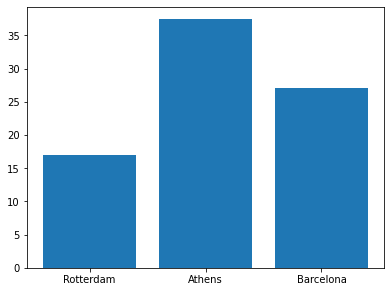

In [67]:
# read train data
df_orders = pd.read_csv("orders.csv", sep=";")
df_products = pd.read_csv("product_attributes.csv", sep=",")
df_dists = pd.read_csv("cities_data.csv", sep=";")
df_product_weight = pd.read_csv("product_weight_class.csv", sep = ",")
df_city_cost = pd.read_csv("cities_data_costs.csv", sep = ",")

# read test data
df_test = pd.read_csv("test.csv", sep=";")

df_orders["origin_port"] = df_orders["origin_port"].replace(["BCN"], "Barcelona")
df_orders["origin_port"] = df_orders["origin_port"].replace(["ATHENAS"], "Athens")


df_products = df_products.merge(df_product_weight, on="product_id")
extra = df_products[df_products["product_id"] == 1692723]
extra["product_id"] = -1
df_products = pd.concat([df_products, extra])
df_city_cost = df_city_cost.drop(["city_from_coord","city_to_coord"], axis=1)
df_orders = df_orders.merge(df_products, on="product_id")



# Cities in the first column from to hub
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["origin_port","logistic_hub","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_from_hub"] = df_orders["distance"]
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_from_hub"] = df_orders["cost_per_unit"]
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_from_hub"] = df_orders["co2_per_unit"]
df_orders = df_orders.drop("co2_per_unit", axis=1)


# Cities in the second column from to hub
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["logistic_hub","origin_port","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_from_hub"],df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_from_hub"],df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_from_hub"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_from_hub"],df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)



# Cities in the first column hub to to
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["logistic_hub","customer","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["logistic_hub"], df_orders["customer"], df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)



# Cities in the second column hub to to
df_orders = df_orders.merge(df_city_cost, how='outer', left_on=["customer","logistic_hub","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_hub_to"],df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_hub_to"],df_orders["cost_per_unit"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_hub_to"],df_orders["co2_per_unit"]))
df_orders = df_orders.drop("co2_per_unit", axis=1)



def isNaN(string):
    return string != string

# Feature engineering for data without hub and total calculus
df_orders = df_orders.merge(df_city_cost, how="outer", left_on=["origin_port","customer","weight_class"], right_on=["city_from_name","city_to_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["distance"], df_orders["distance_from_hub"], df_orders["distance_hub_to"]))
df_orders["distance_ideal"] = list(map(lambda x,y,z: 0 if x == y else z, df_orders["origin_port"], df_orders["customer"], df_orders["distance"]))
df_orders = df_orders.drop("distance", axis=1)
df_orders["cost_per_unit_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["cost_per_unit"], df_orders["cost_per_unit_from_hub"], df_orders["cost_per_unit_hub_to"]))
df_orders = df_orders.drop("cost_per_unit", axis=1)
df_orders["co2_per_unit_total"] = list(map(lambda x,y,z0,z1: y if isNaN(x) else z0 + z1, df_orders["logistic_hub"], df_orders["co2_per_unit"], df_orders["co2_per_unit_from_hub"], df_orders["co2_per_unit_hub_to"]))
df_orders = df_orders.drop("co2_per_unit",axis=1)

df_orders = df_orders.merge(df_city_cost, how="outer", left_on=["origin_port","customer","weight_class"], right_on=["city_to_name","city_from_name","weight_class"])
df_orders = df_orders[list(map(lambda x: True if x == False else False, list(df_orders["order_id"].isnull())))]
df_orders = df_orders.drop(["city_from_name","city_to_name"], axis=1)
df_orders["distance_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_total"], df_orders["distance"]))
df_orders["distance_ideal"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["distance_ideal"], df_orders["distance"]))
df_orders["cost_per_unit_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["cost_per_unit_total"], df_orders["cost_per_unit"]))
df_orders["co2_per_unit_total"] = list(map(lambda x,y: y if np.isnan(x) else x, df_orders["co2_per_unit_total"], df_orders["co2_per_unit"]))
df_orders = df_orders.drop(["distance","cost_per_unit","co2_per_unit"], axis=1)

df_orders["distance_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["distance_total"]))
df_orders["cost_per_unit_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_total"] = list(map(lambda x: 0 if np.isnan(x) else x, df_orders["co2_per_unit_total"]))

df_orders["distance_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["distance_from_hub"], df_orders["distance_total"]))
df_orders["cost_per_unit_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["cost_per_unit_from_hub"], df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_from_hub"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["co2_per_unit_from_hub"], df_orders["co2_per_unit_total"]))
df_orders["distance_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["distance_hub_to"], df_orders["distance_total"]))
df_orders["cost_per_unit_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["cost_per_unit_hub_to"], df_orders["cost_per_unit_total"]))
df_orders["co2_per_unit_hub_to"] = list(map(lambda x,y: y/2 if np.isnan(x) else x, df_orders["co2_per_unit_hub_to"], df_orders["co2_per_unit_total"]))

df_orders["logistic_hub"] = list(map(lambda x: "No" if isNaN(x) else x, df_orders["logistic_hub"]))

df_orders["late_order"] = list(map(int, df_orders["late_order"])) #Ask Pau



country = {}
country['Amsterdam'] = 'Netherlands'
country['Athens'] = 'Greece'
country['Barcelona'] = 'Spain'
country['Berlin'] = 'Germany'
country['Bordeaux'] = 'France'
country['Bratislava'] = 'Slovakia'
country['Bremen'] = 'Germany'
country['Bucharest'] = 'Romania'
country['Budapest'] = 'Hungary'
country['Cologne'] = 'Germany'
country['Copenhagen'] = 'Denmark'
country['Dusseldorf'] = 'Germany'
country['Hamburg'] = 'Germany'
country['Hanover'] = 'Germany'
country['Helsinki'] = 'Finland'
country['Liege'] = 'Belgium'
country['Lille'] = 'France'
country['Lisbon'] = 'Portugal'
country['Lyon'] = 'France'
country['Madrid'] = 'Spain'
country['Malmö'] = 'Sweden'
country['Marseille'] = 'France'
country['Milan'] = 'Italy'
country['Munich'] = 'Germany'
country['Naples'] = 'Italy'
country['Paris'] = 'France'
country['Porto'] = 'Portugal'
country['Prague'] = 'Czech Republic'
country['Rome'] = 'Italy'
country['Rotterdam'] = 'Netherlands'
country['Stockholm'] = 'Sweden'
country['Turin'] = 'Italy'
country['Valencia'] = 'Spain'
country['Venlo'] = 'Netherlands'
country['Vienna'] = 'Austria'
country['Warsaw'] = 'Poland'
country['Zaragoza'] = 'Spain'

df_orders["origin_country"] = list(map(lambda x: country[x], df_orders["origin_port"]))
df_orders["hub_country"] = list(map(lambda x: "No" if x == "No" else country[x], df_orders["logistic_hub"]))
df_orders["customer_country"] = list(map(lambda x: country[x], df_orders["customer"]))


# How good are the origin ports?
rotter = df_orders[df_orders["origin_port"] == "Rotterdam"]
ath = df_orders[df_orders["origin_port"] == "Athens"]
bcn = df_orders[df_orders["origin_port"] == "Barcelona"]

city = ["Rotterdam", "Athens", "Barcelona"]
vals = []
vals.append(100 * sum(rotter["late_order"] == True) / len(rotter))
vals.append(100 * sum(ath["late_order"] == True) / len(ath))
vals.append(100 * sum(bcn["late_order"] == True) / len(bcn))

plt.bar(city,vals)

<BarContainer object of 10 artists>

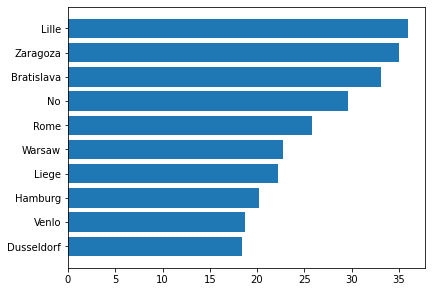

In [68]:
# How good are the hubs?
hubs = df_orders["logistic_hub"].unique()
perc = []
for hub in hubs:
    aux_hub = df_orders[df_orders["logistic_hub"] == hub]
    perc.append(100*sum(aux_hub["late_order"]==True)/len(aux_hub))

perc, hubs = zip(*sorted(zip(perc, hubs)))

plt.barh(hubs, perc)

<BarContainer object of 14 artists>

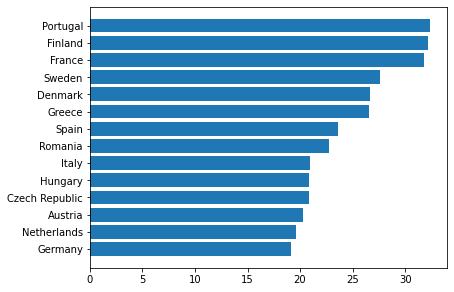

In [69]:
# How good are the customer?

hubs = df_orders["customer_country"].unique()
perc = []
for hub in hubs:
    aux_hub = df_orders[df_orders["customer_country"] == hub]
    perc.append(100*sum(aux_hub["late_order"]==True)/len(aux_hub))

perc, hubs = zip(*sorted(zip(perc, hubs)))
    
plt.barh(hubs, perc)

In [ ]:
busy_road = {}
busy_road['Bulgaria'] = 171.1
busy_road['Czech Republic'] = 96.7
busy_road['Italy'] = 77.7
busy_road['Germany'] = 72.1
busy_road['Romania'] = 65.7
busy_road['Switzerland'] = 64.9
busy_road['Netherlands'] = 61.8
busy_road['Portugal'] = 55.9
busy_road['Poland'] = 53.0
busy_road['Belgium'] = 48.4
busy_road['Ukraine'] = 46.2
busy_road['Greece'] = 44.9
busy_road['Slovakia'] = 38.8
busy_road['Russia'] = 38.0
busy_road['Denmark'] = 35.8
busy_road['Austria'] = 33.4
busy_road['Spain'] = 33.1
busy_road['France'] = 30.7
busy_road['Norway'] = 28.7
busy_road['Slovenia'] = 28.7
busy_road['Hungary'] = 16.0
busy_road['Sweden'] = 8.3
busy_road['Finland'] = 5.8


scaler = StandardScaler() 
valor_pais = scaler.fit_transform(np.array(list(busy_road.values())).reshape(-1,1)).flatten()
i = 0
for key in busy_road.keys():
    busy_road[key] = valor_pais[i]
    i+=1


nom_pais = ["Norway", "Switzerland", "Sweden", "-", "Denmark", "Spain", "Ireland", "Netherlands", "Germany", "Austria", "Slovenia", "France", "Finland", "Italy", "Luxembourg", "Belgium","-", "Slovakia", "Hungary", "Czech Republic", "Portugal", "-", "Greece", "-", "-", "Poland", "Bulgaria", "-", "Romania", "Russia", "Ukraine"]
valor_pais = [17, 17, 18, 21, 27, 29, 30 , 31, 33, 38, 38, 39, 40, 40, 42, 44, 45, 45, 46, 48, 52, 54, 54, 58, 63, 65, 67, 74, 85, 100, 93]

scaler = StandardScaler() 
valor_pais = scaler.fit_transform(np.array(valor_pais).reshape(-1,1)).flatten()

road_accidents = dict()
for nom,valor in zip(nom_pais,valor_pais):
    road_accidents[nom] = valor

hash_ACR = ["NO", "CH", "SE", "-", "DK", "ES", "IE", "NL","DE","AT", "SI","FR","FI","IT","LU","BE", "SK","HU","CZ","PT","GR","PL","BG","RO","RU","UA"]
hash_key = {x:y for x,y in zip(list(road_accidents.keys()),hash_ACR)}



import graph
from borders import country_border_graph, country_code_lookup, find_shortest_path


def find_paths(origen, destination):
    '''
    Takes the origin and destination in format: "IT"
    Returns a list with the names of the path between origin and destination in format: "Italy"
    '''
    path = find_shortest_path(country_border_graph, origen, destination)
    path_names = [country_code_lookup[code] for code in path]
    return path_names


def all_paths(origen, hub, destination):
    if hub == 'No':
        return find_paths(hash_key[origen], hash_key[destination])
    
    paths = find_paths(hash_key[origen], hash_key[hub])
    paths.extend(find_paths(hash_key[hub], hash_key[destination]))
    
    return list(set(paths))

df_orders["col_aux"] = list(map(all_paths, df_orders["origin_country"], df_orders["hub_country"], df_orders["customer_country"]))

# Find all the countries we went through
paisos_set = set()
for i in range(len(df_orders)):
    for x in df_orders.loc[i]["col_aux"]:
        paisos_set.add(x)

# Add new column for each country
for i in list(paisos_set):
    df_orders[i] = np.zeros(len(df_orders))

for col in df_orders.columns[27:-1]:
    df_orders[col] = list(map(lambda x: 1 if col in x else 0, df_orders["col_aux"]))


cols = df_orders.columns[27:-1]
perc = []
for col in cols:
    went_through_country = df_orders[df_orders[col] == 1]
    perc.append(100*sum(went_through_country["late_order"]==1)/len(went_through_country) )
    
plt.barh(cols, perc)

## Building Hubs

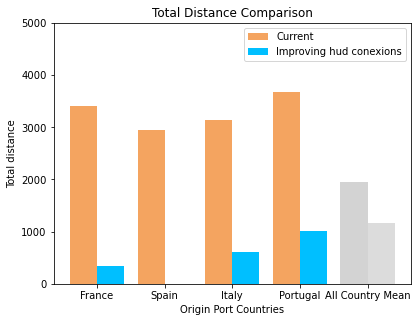

In [63]:
df_orders["loss_per_unit"] = list(map(lambda x,y,z: 0 if (y == 0 or y - z < 1) else x*z/y, df_orders["cost_per_unit_total"], df_orders["distance_total"], df_orders["distance_ideal"]))
df_orders["loss_per_unit"].describe()

df_orders["co2_per_unit_wastage"] = list(map(lambda x,y,z: 0 if (y == 0 or y - z < 1) else x*z/y, df_orders["co2_per_unit_total"], df_orders["distance_total"], df_orders["distance_ideal"]))
df_orders["co2_per_unit_wastage"].describe()

df_orders["distance_diff"] = df_orders["distance_total"] - df_orders["distance_ideal"]


large_diff = df_orders[df_orders["distance_diff"] > 1000]


extreme_large_diff = large_diff[large_diff["distance_diff"] > 2500]


bcn_extreme_large_diff = extreme_large_diff[extreme_large_diff["origin_port"] == "Barcelona"]
ath_extreme_large_diff = extreme_large_diff[extreme_large_diff["origin_port"] == "Athens"]
rot_extreme_large_diff = extreme_large_diff[extreme_large_diff["origin_port"] == "Rotterdam"]


# Uncomment those lines for different port visualization
#bcn_extreme_large_diff = ath_extreme_large_diff
#bcn_extreme_large_diff = rot_extreme_large_diff



cus_country = bcn_extreme_large_diff["customer_country"].unique()
dist_dif = []
ideal_dist = []
for col in cus_country:
    dist_dif.append(bcn_extreme_large_diff[bcn_extreme_large_diff["customer_country"] == col].iloc[0]["distance_total"])
    ideal_dist.append(bcn_extreme_large_diff[bcn_extreme_large_diff["customer_country"] == col].iloc[0]["distance_ideal"])
    
dist_dif.append(np.mean(df_orders["distance_total"]))
ideal_dist.append(np.mean(df_orders["distance_ideal"]))
            
cus_country = list(cus_country)
cus_country.append("All Country Mean")


X_axis = np.arange(len(dist_dif))
colors = ["sandybrown"]*(len(cus_country)-1)
colors2 = ["deepskyblue"]*(len(cus_country)-1)
colors.append("lightgrey")
colors2.append("gainsboro")
plt.bar(X_axis - 0.2, dist_dif, 0.4, label = "Current", color = colors)
plt.bar(X_axis + 0.2, ideal_dist, 0.4, label = "Improving hud conexions", color = colors2)
plt.xticks(X_axis, cus_country)
plt.xlabel("Origin Port Countries")
plt.ylabel("Total distance")
plt.ylim(0, 5000)
plt.title("Total Distance Comparison")
plt.legend()


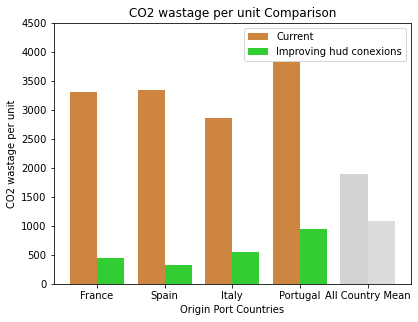

In [64]:
co2_per_unit = []
units = []
cost_per_unit = []
distance_diff = []
total_units = []

co2_loss = []
cost_loss = []

for col in cus_country[:-1]:
    aux_df = bcn_extreme_large_diff[bcn_extreme_large_diff["customer_country"] == col]
    co2_per_unit.append(np.mean(aux_df["co2_per_unit_total"]))
    units.append(np.mean(aux_df["units"]))
    cost_per_unit.append(np.mean(aux_df["cost_per_unit_total"]))
    total_units.append(np.sum(aux_df["units"]))
    
    co2_loss.append(np.mean(aux_df["co2_per_unit_wastage"]))
    cost_loss.append(np.mean(aux_df["loss_per_unit"]))
                         
co2_loss.append(np.mean(df_orders["co2_per_unit_wastage"]))
cost_loss.append(np.mean(df_orders["loss_per_unit"]))

co2_per_unit.append(np.mean(df_orders["co2_per_unit_total"]))
cost_per_unit.append(np.mean(df_orders["cost_per_unit_total"]))



X_axis = np.arange(len(cus_country))
colors = ["peru"]*(len(cus_country)-1)
colors2 = ["limegreen"]*(len(cus_country)-1)
colors.append("lightgrey")
colors2.append("gainsboro")
plt.bar(X_axis - 0.2, co2_per_unit, 0.4, label = "Current", color = colors)
plt.bar(X_axis + 0.2, co2_loss, 0.4, label = "Improving hud conexions", color = colors2)
plt.xticks(X_axis, cus_country)
plt.ylim(0, 4500)
plt.xlabel("Origin Port Countries")
plt.ylabel("CO2 wastage per unit")
plt.title("CO2 wastage per unit Comparison")
plt.legend()

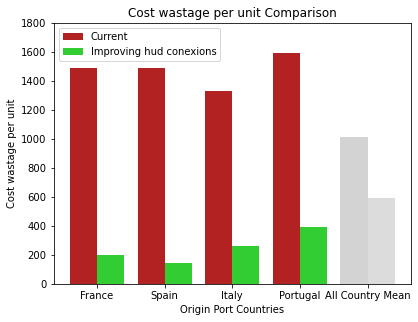

In [65]:
X_axis = np.arange(len(co2_per_unit))

colors = ["firebrick"]*(len(cus_country)-1)
colors2 = ["limegreen"]*(len(cus_country)-1)
colors.append("lightgrey")
colors2.append("gainsboro")

plt.bar(X_axis - 0.2, cost_per_unit, 0.4, label = "Current", color = colors)
plt.bar(X_axis + 0.2, cost_loss, 0.4, label = "Improving hud conexions", color = colors2)#limegreen
plt.xticks(X_axis, cus_country)
plt.ylim(0,1800)
plt.xlabel("Origin Port Countries")
plt.ylabel("Cost wastage per unit")
plt.title("Cost wastage per unit Comparison")
plt.legend()